During this data analysis, a dataset of online shopping website activity (each row representing details about one user while being on the website) will be extracted from RDS database, cleaned using various statistical methods, then will be analysed to answer some questions which will contribute to make informed decisions about changes to the website and marketing strategies.

Import required packages:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

Import required modules:

In [2]:
import db_utils
import datatype_transform
import dataframe_transform
import dataframe_info
import plotter

Import data from RDS database:

In [3]:
customer_activity_class = db_utils.RDSDatabaseConnector(db_utils.yaml_dictionary)
engine = customer_activity_class.connect_database()
customer_activity = customer_activity_class.extract_data(engine)

Convert data types:

In [4]:
# Get the data type for each column
print('Data types before the transformation:')
print(customer_activity.dtypes)
         
# Covert data types for some columns to category 
customer_activity_DataTransform = datatype_transform.DatatypeTransform(customer_activity)
columns_to_transform = ['administrative', 'product_related', 'informational', 
                        'month', 'operating_systems', 'browser', 'region', 
                        'traffic_type', 'visitor_type']
for column in columns_to_transform:
    customer_activity_DataTransform.convert_to_category(column)
    
# Check if the columns have been transformed correctly  
print('\n')  
print('Data types after the transformation:')
print(customer_activity.dtypes)

Data types before the transformation:
administrative              float64
administrative_duration     float64
informational                 int64
informational_duration      float64
product_related             float64
product_related_duration    float64
bounce_rates                float64
exit_rates                  float64
page_values                 float64
month                        object
operating_systems            object
browser                      object
region                       object
traffic_type                 object
visitor_type                 object
weekend                        bool
revenue                        bool
dtype: object


Data types after the transformation:
administrative              category
administrative_duration      float64
informational               category
informational_duration       float64
product_related             category
product_related_duration     float64
bounce_rates                 float64
exit_rates                   float64
p

Following columns have been converted to category data type:
- administrative
- informational
- product_related
- month
- operating_systems
- browser
- region
- traffic_type
- visitor_type

Put columns into different groups based on data types:

In [5]:
all_columns = customer_activity.columns
numeric_columns = ['administrative_duration', 'informational_duration', 'product_related_duration',
                   'bounce_rates', 'exit_rates', 'page_values']
categorical_columns = ['administrative', 'informational', 'product_related', 'month',
                       'operating_systems', 'browser', 'region', 'visitor_type']
boolean_columns = ['weekend', 'revenue']

Create instances of the classes:

In [6]:
customer_activity_info = dataframe_info.DataFrameInfo(customer_activity)
customer_activity_plot = plotter.Plotter(customer_activity)
customer_activity_transform = dataframe_transform.DataFrameTransform(customer_activity)

Get statistical summaries for numeric columns:

In [7]:
customer_activity_info.get_description()

# Get median as well
for column in numeric_columns:
    customer_activity_info.get_median(column)

Description for numeric columns:
       administrative_duration  informational_duration  \
count             11418.000000            11994.000000   
mean                 84.539079               34.486687   
std                 179.392485              136.201557   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%                   6.000000                0.000000   
75%                  95.000000                0.000000   
max                2155.000000             1988.750000   

       product_related_duration  bounce_rates    exit_rates   page_values  
count              12129.000000  12330.000000  12330.000000  12330.000000  
mean                1192.426086      0.022381      0.042820      5.556310  
std                 1767.243802      0.048847      0.048578     17.397345  
min                    0.000000      0.000000      0.000000      0.000000  
25%                  192.000000      0.000000      0.014000     

For categorical columns and boolean columns, get distinct count values for each column and plot bar charts:

Counts for distinct values for administrative
   administrative  counts
0             0.0    5644
1             1.0    1237
2             2.0    1018
3             3.0     885
4             4.0     661
5             5.0     541
6             6.0     401
7             7.0     314
8             8.0     259
9             9.0     227
10           10.0     165
11           11.0      97
12           12.0      93
13           13.0      65
14           14.0      42
15           15.0      37
16           16.0      25
17           17.0      15
18           18.0      14
19           19.0       5
20           21.0       5
21           23.0       4
22           24.0       4
23           20.0       2


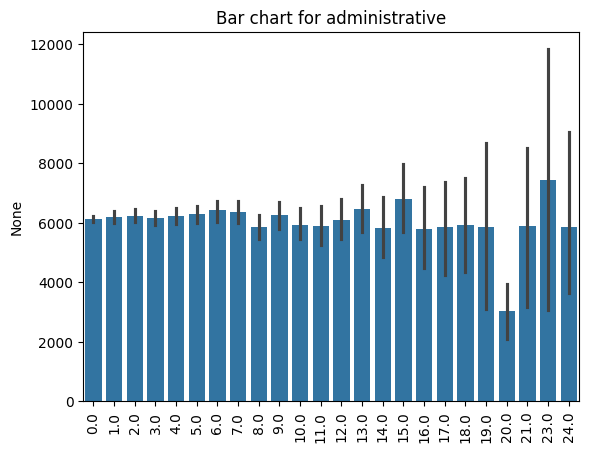

Counts for distinct values for informational
   informational  counts
0              0    9595
1              1    1105
2              2     763
3              3     426
4              4     215
5              5     101
6              6      74
7              7      26
8              8      12
9              9       6
10            12       4
11            10       2
12            11       1


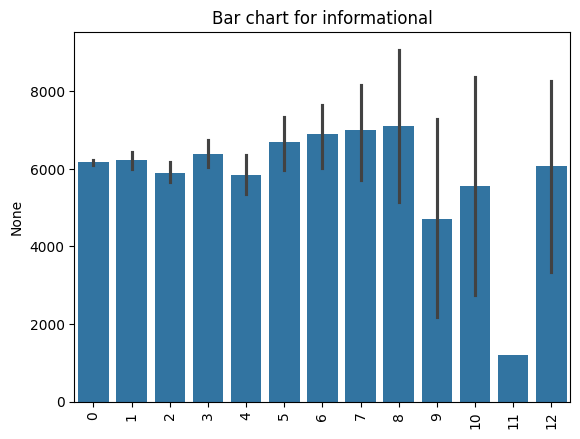

Counts for distinct values for product_related
    product_related  counts
0               1.0     582
1               2.0     426
2               3.0     422
3               5.0     385
4               6.0     378
..              ...     ...
291           278.0       1
292           279.0       1
293           282.0       1
294           291.0       1
295           485.0       1

[296 rows x 2 columns]


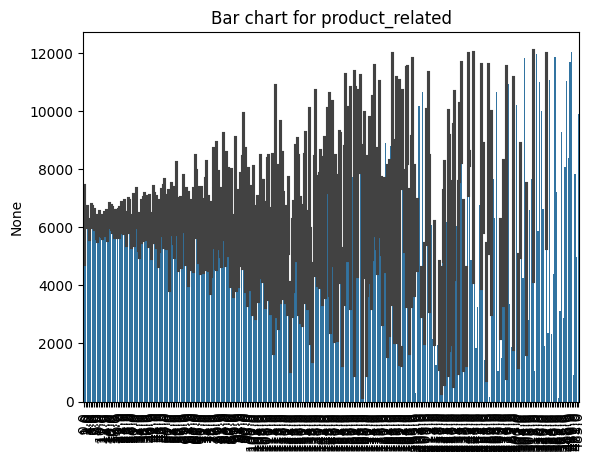

Counts for distinct values for month
  month  counts
0   May    3332
1   Nov    2959
2   Dec    1828
3   Mar    1807
4   Oct     598
5   Sep     462
6   Aug     457
7   Jul     441
8  June     247
9   Feb     199


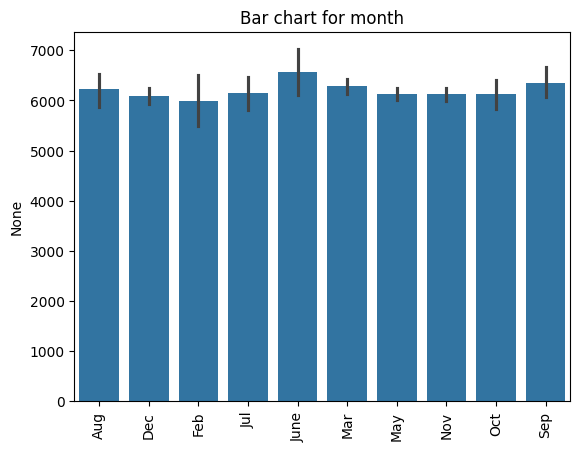

Counts for distinct values for operating_systems
  operating_systems  counts
0           Windows    6596
1             MACOS    2676
2           Android    2584
3               iOS     385
4          ChromeOS      62
5            Ubuntu       9
6             Other       7


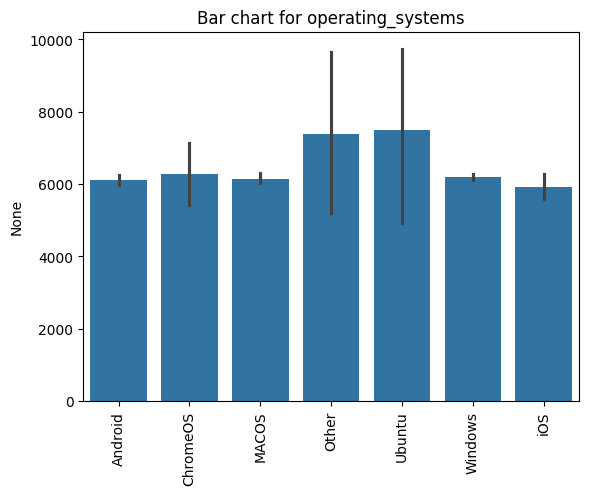

Counts for distinct values for browser
              browser  counts
0       Google Chrome    7721
1              Safari    2527
2     Mozilla Firefox     830
3      Microsoft Edge     582
4   Internet Explorer     156
5    Samsung Internet     145
6               Opera     136
7             Android     121
8                  QQ      53
9      Sogou Explorer      47
10             Yandex       8
11         UC Browser       2
12       Undetermined       2


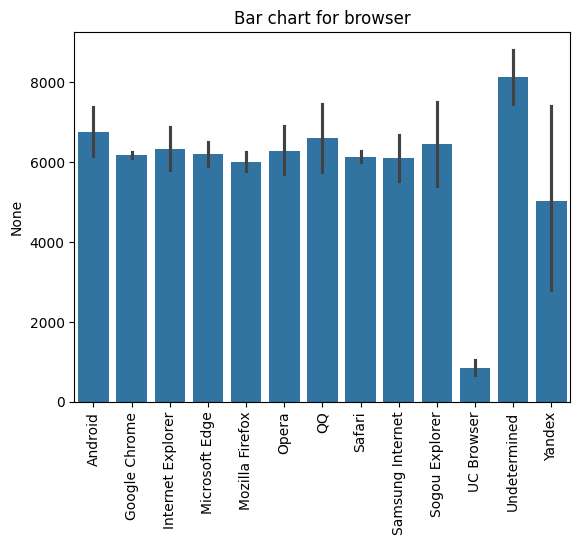

Counts for distinct values for region
            region  counts
0    North America    4869
1   Western Europe    2283
2   Eastern Europe    1154
3             Asia    1143
4    South America     913
5           Africa     770
6  Northern Africa     499
7  Southern Africa     423
8          Oceania     276


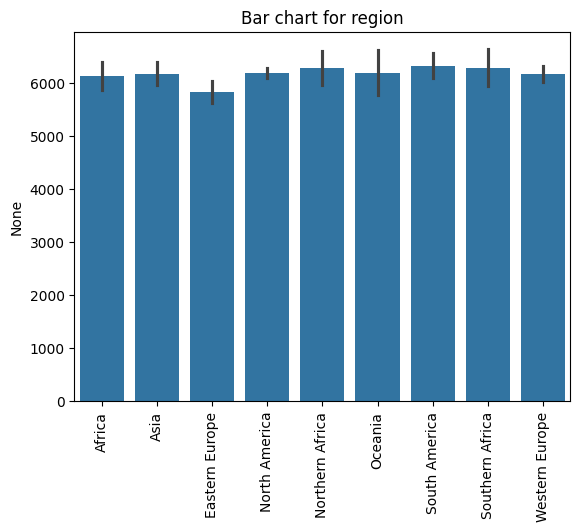

Counts for distinct values for visitor_type
        visitor_type  counts
0  Returning_Visitor   10691
1        New_Visitor    1570
2              Other      69


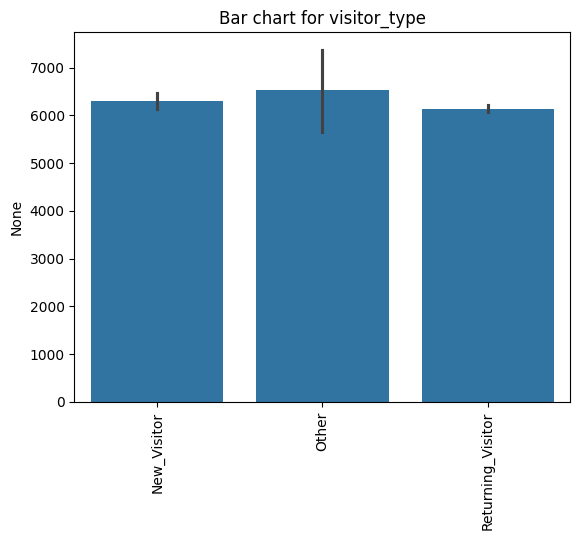

Counts for distinct values for weekend
   weekend  counts
0    False    9785
1     True    2545


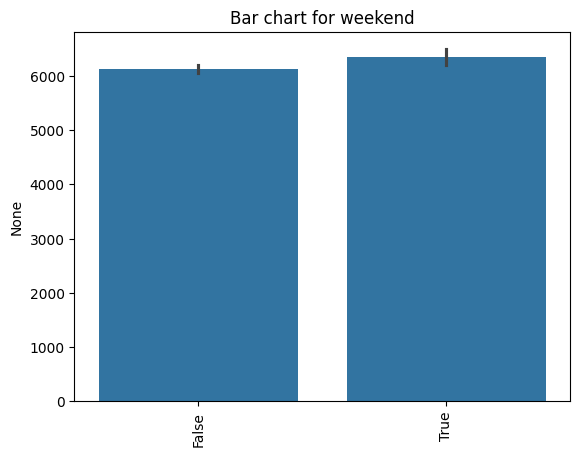

Counts for distinct values for revenue
   revenue  counts
0    False   10421
1     True    1909


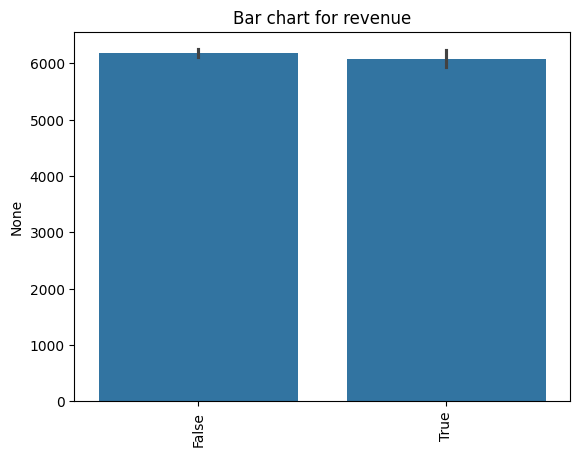

In [8]:
for column in categorical_columns:
    customer_activity_info.get_counts(column)
    customer_activity_plot.plot_barchart(column)    
    
for column in boolean_columns:
    customer_activity_info.get_counts(column)
    customer_activity_plot.plot_barchart(column)

Get the information for the amount of missing values in each column:

In [9]:
for column in all_columns:
    customer_activity_info.get_NULL_counts(column)

Number of NULLs for administrative: 570
Percentage of NULLs for administrative: 4.62 %
Number of NULLs for administrative_duration: 912
Percentage of NULLs for administrative_duration: 7.4 %
Number of NULLs for informational: 0
Percentage of NULLs for informational: 0.0 %
Number of NULLs for informational_duration: 336
Percentage of NULLs for informational_duration: 2.73 %
Number of NULLs for product_related: 579
Percentage of NULLs for product_related: 4.7 %
Number of NULLs for product_related_duration: 201
Percentage of NULLs for product_related_duration: 1.63 %
Number of NULLs for bounce_rates: 0
Percentage of NULLs for bounce_rates: 0.0 %
Number of NULLs for exit_rates: 0
Percentage of NULLs for exit_rates: 0.0 %
Number of NULLs for page_values: 0
Percentage of NULLs for page_values: 0.0 %
Number of NULLs for month: 0
Percentage of NULLs for month: 0.0 %
Number of NULLs for operating_systems: 11
Percentage of NULLs for operating_systems: 0.09 %
Number of NULLs for browser: 0
Percen

Following columns contain missing values:
- administrative
- administrative_duration
- informational_duration
- product_related
- product_related_duration
- operating_systems

For categorical columns (administrative, product_realted, and operating_systems),
mode imputation will be used.
For numeric columns (administrative_duration, informational_duration, and product_related_duration) if
it is skewed median imputation will be used and if it is symmetrical mean 
imputation will be used.

Check the skewness for these three numeric columns with missing values:

In [10]:
numeric_columns_missing_values = ['administrative_duration', 'informational_duration', 'product_related_duration']
for column in numeric_columns_missing_values:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 4.67
Skew of informational_duration is 7.2
Skew of product_related_duration is 3.64


They are all right skewed so median imputation will be conducted:

In [11]:
# Compute median imputation for the numeric columns with missing values
for column in numeric_columns_missing_values:
    customer_activity_transform.median_impute(column)
    
# Compute mode imputation for the categorical columns with missing values
categorical_columns_missing_values = ['administrative', 'product_related', 'operating_systems']
for column in categorical_columns_missing_values:
    customer_activity_transform.mode_impute(column)
    
# Check if the imputation has been successful
columns_missing_values = numeric_columns_missing_values + categorical_columns_missing_values
for column in columns_missing_values:
    customer_activity_info.get_NULL_counts(column)

Number of NULLs for administrative_duration: 0
Percentage of NULLs for administrative_duration: 0.0 %
Number of NULLs for informational_duration: 0
Percentage of NULLs for informational_duration: 0.0 %
Number of NULLs for product_related_duration: 0
Percentage of NULLs for product_related_duration: 0.0 %
Number of NULLs for administrative: 0
Percentage of NULLs for administrative: 0.0 %
Number of NULLs for product_related: 0
Percentage of NULLs for product_related: 0.0 %
Number of NULLs for operating_systems: 0
Percentage of NULLs for operating_systems: 0.0 %


Get information for skewness for all numeric columns:

In [12]:
for column in numeric_columns:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 4.84
Skew of informational_duration is 7.3
Skew of product_related_duration is 3.68
Skew of bounce_rates is 2.95
Skew of exit_rates is 2.19
Skew of page_values is 6.02


Plot histograms to visualise the skewness:

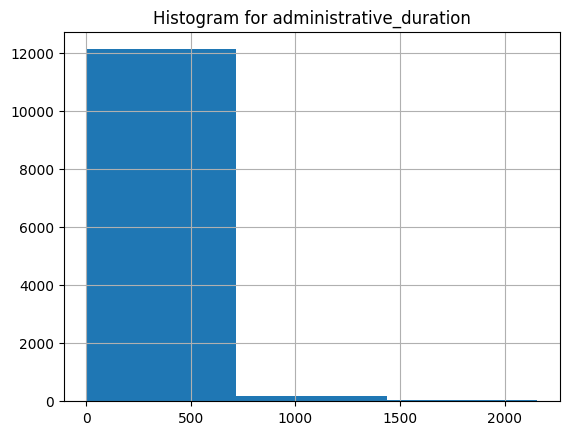

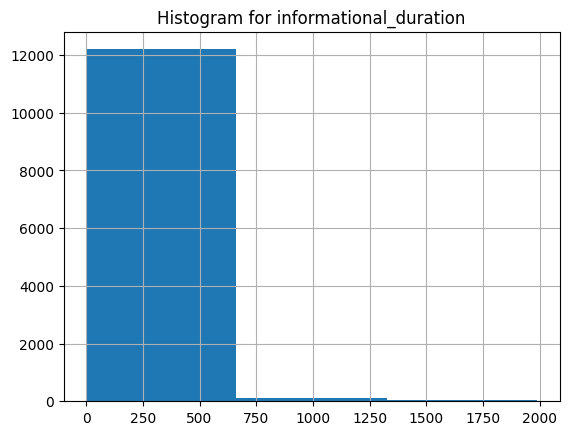

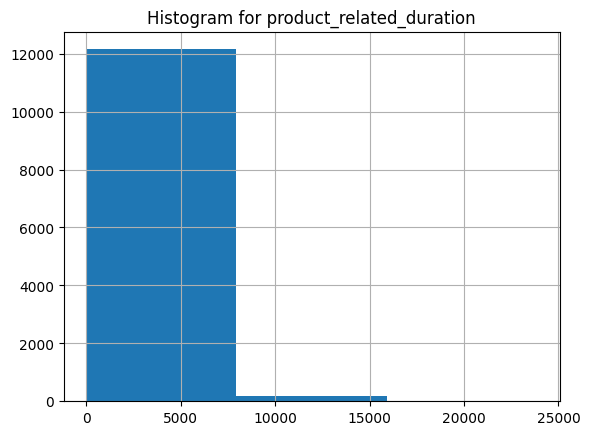

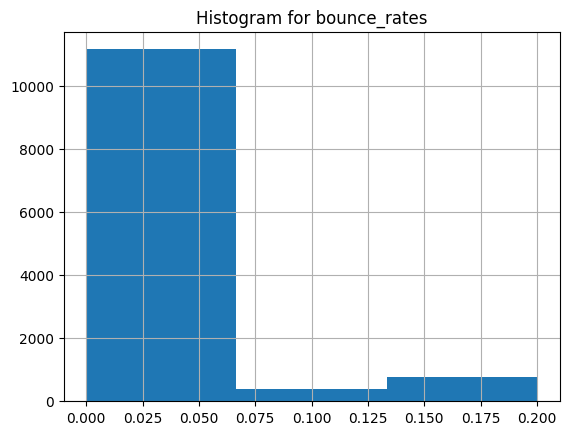

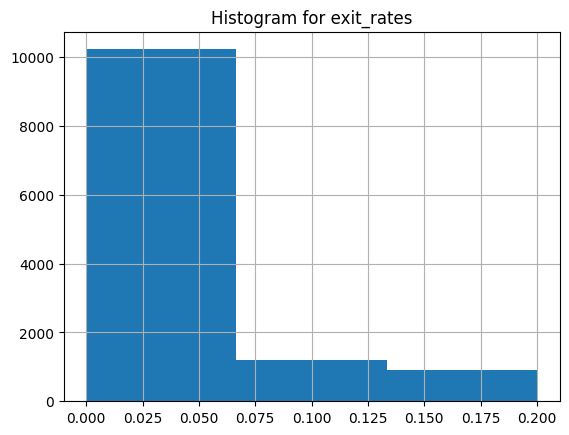

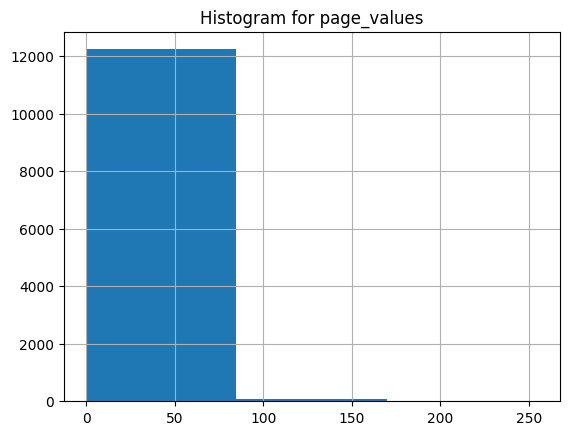

In [13]:
for column in numeric_columns:
    customer_activity_plot.plot_histograms(column)

Conduct Yeo-Johnson transform on the numeric columns:

In [14]:
for column in numeric_columns:
    customer_activity_transform.yeo_johnson_transform(column)
    
# Check the skewness again
for column in numeric_columns:
    customer_activity_info.get_skewness(column)

Skew of administrative_duration is 0.16
Skew of informational_duration is 1.51
Skew of product_related_duration is -0.03
Skew of bounce_rates is 1.02
Skew of exit_rates is 0.42
Skew of page_values is 1.35


Get z_scores for numeric columns to find outliers:

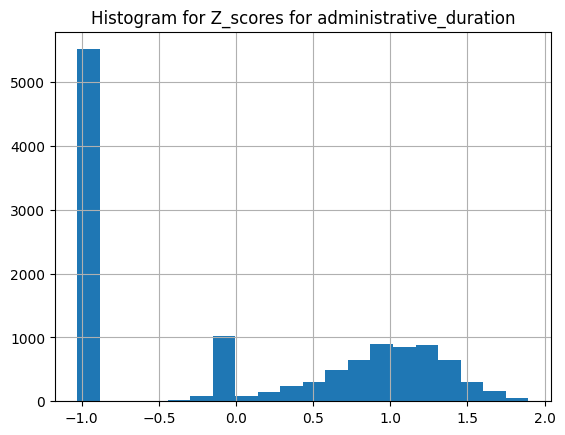

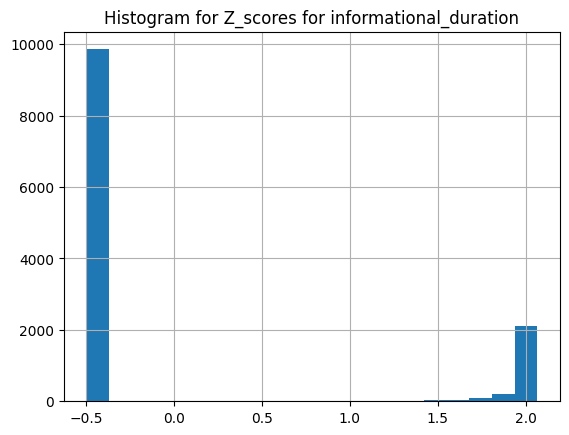

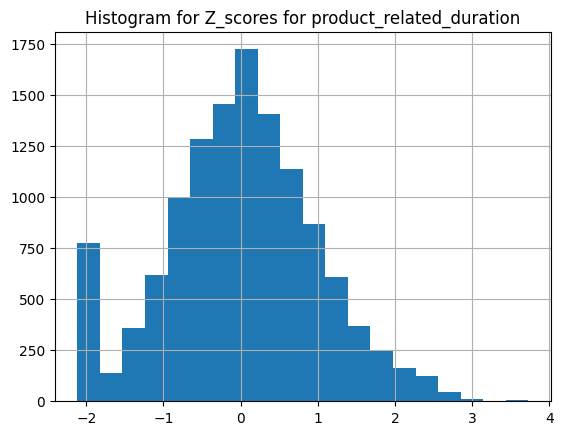

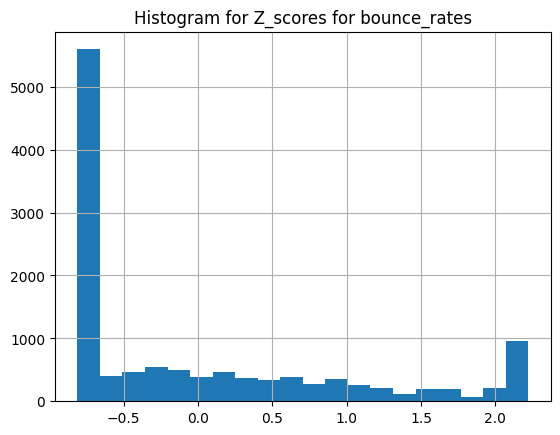

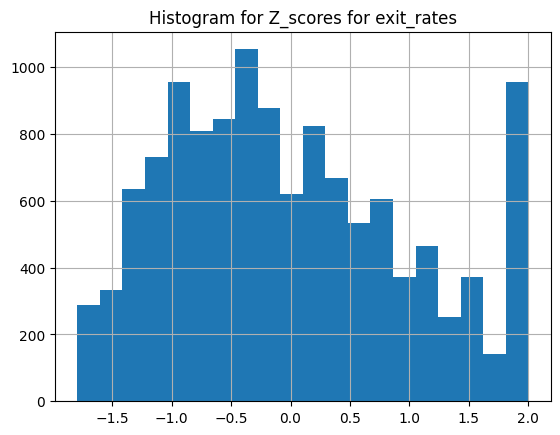

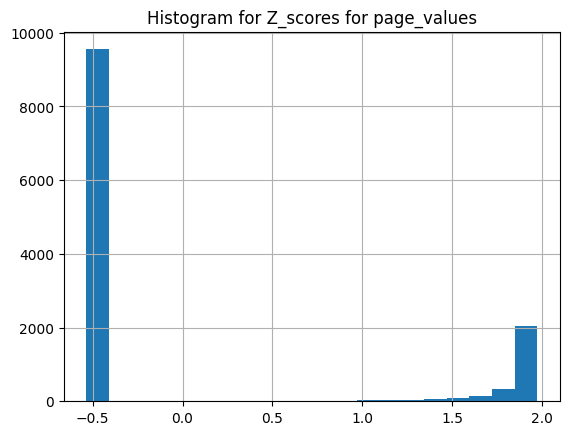

In [15]:
z_scores = {}
for column in numeric_columns:
    z_scores[column] = customer_activity_info.get_zscores(column)
    
# Plot histograms for z_scores for each numeric column
for column in z_scores:
    pd.Series(z_scores[column]).hist(bins = 20)
    plt.title(f'Histogram for Z_scores for {column}')
    plt.show()
    
    

If we consider z_scores greater than +3 or less then -3 as outliers, only product_related_duration
column contains a small number of outliers which will be dropped. 

In [16]:
# Get z_scores for product_related_duration column
product_related_duration_zscores = customer_activity_info.get_zscores('product_related_duration')

# Get shape for the DataFrame before the conversion
print('Shape of the DataFrame before removing the outliers:', customer_activity.shape)

# Add it to the DataFrame as a new column
customer_activity['z_scores'] = product_related_duration_zscores

# Drop outliers from the DataFrame
customer_activity_transform.drop_outliers('z_scores')

# Drop the z_scores column from the DataFrame
customer_activity_transform.drop_column('z_scores')

# Check the shape of the DataFrame after the conversion
print('Shepe of the DataFrame after removing outliers:', customer_activity.shape)


Shape of the DataFrame before removing the outliers: (12330, 17)
Shepe of the DataFrame after removing outliers: (12321, 17)


Check for collinearity:

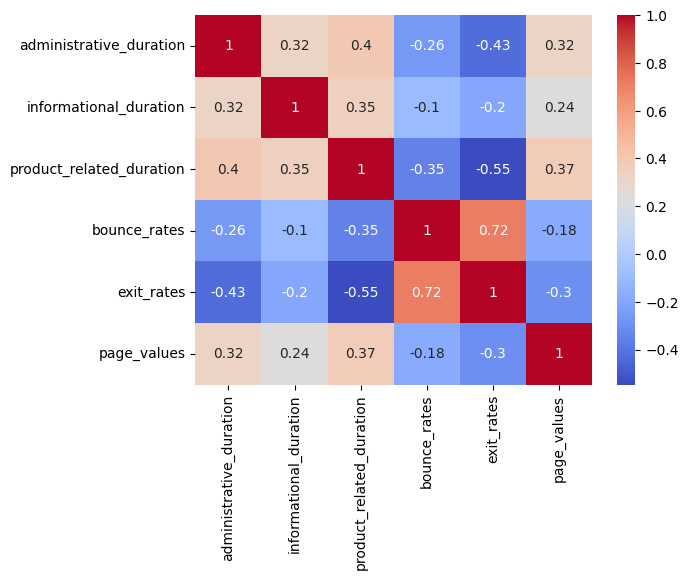

In [17]:
# Create a new DataFrame with only numeric values
numeric_df = customer_activity[numeric_columns]
numeric_df_plotter = plotter.Plotter(numeric_df)
numeric_df_plotter.plot_correlation_matrix()

There does not seem to be any issues with collineaity on this DataFrame.

Save the cleaned DataFrame:

In [18]:
db_utils.save_data(customer_activity, customer_activity.csv)

AttributeError: 'DataFrame' object has no attribute 'csv'

The cleaned DataFrame will be analysed to answer questions in following sections:
- S1 - General overview of the performance of the website
- S2 - Which softwares customers are using to visit the website
- S3 - Investigate the traffic coming to the website
- S4 - Where the website revenue is being generated

S1Q1: Are sales proportionally happening more on weekends?

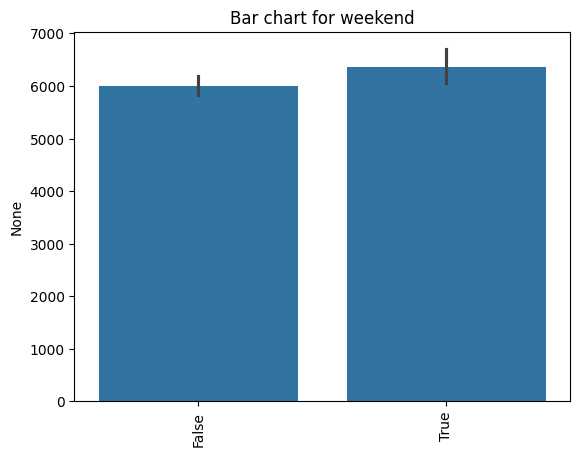

In [19]:
# Filter the DataFrame for rows where revenue is True (the customer purachesed during that session) 
revenue_true = customer_activity[customer_activity['revenue'] == True]

# Create a new class instance for the filtered DataFrame
revenue_true_plot = plotter.Plotter(revenue_true)

# Plot a bar chart for the weekend column
revenue_true_plot.plot_barchart('weekend')

No, there does not seem to be much difference in the amount of sales for the activities took place during the weekend only or not.

S1Q2: Which regions are generating the most revenue currently?

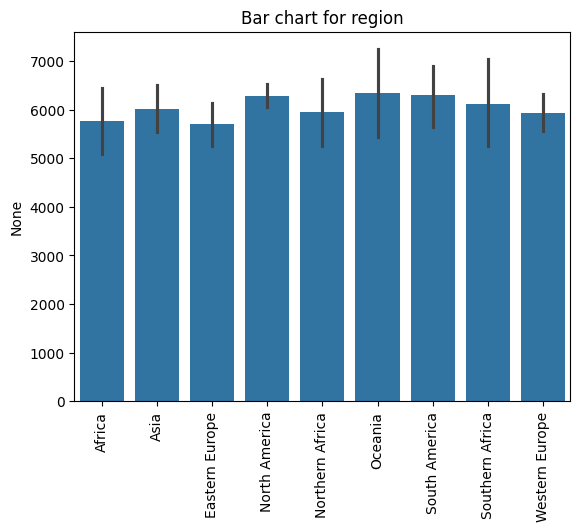

In [20]:
# Plot a bar chart for the region column
revenue_true_plot.plot_barchart('region')

There is not much difference in revenues across all regions.

S1Q3: Is there any particular website traffic that stands out when generating sales?

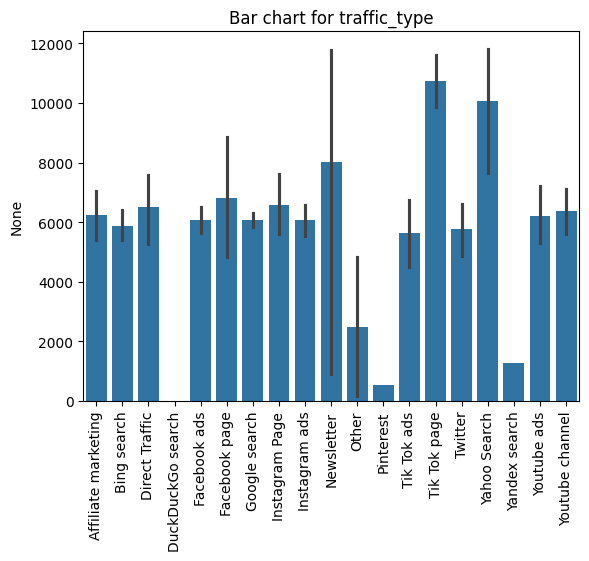

In [21]:
# Plot a bar chart for traffic type column 
revenue_true_plot.plot_barchart('traffic_type')

Yes, Tik Tok page, Yahoo search, and Newsletter.

S1Q4: What percentage of time is spent on the website performing administrative/product or informational related tasks?

S1Q5: Are there any informational/administrative tasks which users spend time doing most?

S1Q6: What is the breakdown of months making the most sales?

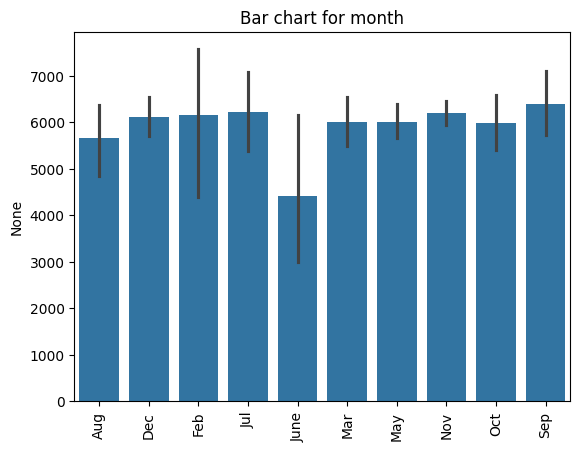

In [22]:
# Plot a bar chart for months
revenue_true_plot.plot_barchart('month')

September has the highest mean value, however if we compare the max values, February is the highest.

S2Q1: The count of the operating systems used to visit the site and the percentage of the total

In [23]:
# Get counts for each operating system
counts = customer_activity_info.get_counts('operating_systems')

# 



Counts for distinct values for operating_systems
  operating_systems  counts
0           Windows    6602
1             MACOS    2676
2           Android    2580
3               iOS     385
4          ChromeOS      62
5            Ubuntu       9
6             Other       7
